# Low-Level Programmierung von maschinellem Lernen: Implementation einer Support Vector Machine ohne Hilfe von externen Bibliotheken und anschließendes Training mit Hilfe eines künstlichen Datensatzes

von Thomas Battenfeld \

Quelle: <a href ="https://pdfs.semanticscholar.org/53fc/c056f79e04daf11eb798a7238e93699665aa.pdf?_ga=2.244554757.1233975175.1575631299-132689507.1565621253"> John C. Platt - A Fast Algorithm for Training Support Vector Machines</a>

Eine Support Vector Machine (SVM) teilt einen n-dimensionalen Raum mit Hilfe einer n-1-dimensionalen Hyperebene. Diese Entscheidungsfunktion kann folgendermaßen beschrieben werden:

$$u= w \cdot x - b,$$

wobei\
$\ \ \ \ \ \ -$ ${w}$ den Normalenvektor zu der Hyperebene,\
$\ \ \ \ \ \ -$ ${x}$ den Eingabevektor und\
$\ \ \ \ \ \ -$ $b$ einen skalaren Schwellwert darstellt.

Eine SVM soll eine Hyperebene finden, die zwei Klassen trennt, d.h. ${w} \cdot {x} - b = 0$. 

Für Instanzen der Klasse ''$-1$'' soll $w \cdot x - b \leq -1$ gelten, während für Instanzen der Klasse ''$1$'' $w \cdot x - b \geq 1$ gelten soll.
Dazu soll der Abstand $a$ der Hyperebene zu den beiden Klassen möglichst groß sein. Dieser Abstand kann als

$$a = \frac{1}{||{w}||_2}$$

formuliert werden. Die Maximierung dieses Abstands kann durch das folgende Optimierungsproblem erfolgen:

\begin{equation}
    \begin{array}{lll}
        \min &\frac{1}{2} ||w||^2 & \\
        \mbox{s.t.} & y_i(w \cdot x_i - b) \geq 1 &\forall i,
    \end{array}
\end{equation}

wobei $x_i$ den $i$-ten Trainingsdatensatz und $y_i$ das Label des $i$-ten Trainingsdatensatzes darstellt.
Da die Daten häufig nicht linear trennbar sind, wurden von Cortes & Vapnik 1995 Regularisierungsparameter sowie ein Strafterm eingeführt:

\begin{equation}
    \begin{array}{lll}
        \min &\frac{1}{2} ||w||^2 + C \sum^N_{i=1} \xi_i &\\
        \mbox{s.t.} & y_i(w \cdot x_i - b) \geq 1 - \xi_i &\forall i, \\
    \end{array}
\end{equation}

wobei $\xi_i$ Schlupfvariablen sind, die Datenpunkten innerhalb des Abstands $a$ zulassen. $C$ stellt den korrespondierenden Strafterm dar.
Dieses Optimierungsproblem kann in einer dualen Form und mit Hilfe von Lagrange-Multiplikatoren formuliert werden:

\begin{equation}
    \begin{array}{ll}
        \min& \frac{1}{2} \sum^N_{i=1} \sum^N_{j=1} y_i y_j K(x_i, x_j) \alpha_i \alpha_j -  \sum^N_{i=1} \alpha_i \\
        \mbox{s.t.} & 0 \leq \alpha_i \leq C \  \ \ \ \ \ \ \ \ \forall i, \\
        & \sum^N_{i=1} y_i \alpha_i = 0,
    \end{array}
\end{equation}

wobei \
$\ \ \ \ \ \ -$ $N$ die Anzahl der Trainingsdatensätze ist, \
$\ \ \ \ \ \ -$ $K$ eine Kernelfunktion ist und \
$\ \ \ \ \ \ -$ $\alpha$ Lagrange-Multiplikatoren darstellen.

Mit Hilfe der Lagrange-Multiplikatoren ist das Auffinden der lokalen Maxima und Minima einer Funktion (welche Nebenbedingungen unterliegt) möglich.
Des Weiteren unterliegt das Optimierungsproblem den folgenden Karush-Kuhn-Tucker Bedingungen:

\begin{equation}
    \begin{array}{lcl}
        \alpha_i = 0 & \Leftrightarrow & y_i u_i \geq 1, \\
        0 < \alpha_i < C & \Leftrightarrow & y_i u_i = 1, \\
        \alpha_i = C & \Leftrightarrow & y_i u_i \leq 1.
    \end{array}
\end{equation}

Karush-Kuhn-Tucker Bedingungen stellen die notwendigen Voraussetzungen dafür dar, dass eine Lösung in der nicht linearen Programmierung optimal sein kann. 
Die korrespondierende Entscheidungsfunktion zu dem oben genannten dualen Problem wird folgendermaßen definiert:

$$u = \sum^N_{j=1}y_j \alpha_j K(x_j,x)-b.$$

# Support Vector Machines mit Sequential Minimal Optimization nach John C. Platt "A Fast Algorithm for Training Support Vector Machines" (1998)

Eine Möglichkeit dieses duale Problem zu lösen stellt die Sequential Minimal Optimization (SMO) dar. Diese Heuristik wurde im Jahr 1988 vom John C. Platt in dem Paper <a href ="https://pdfs.semanticscholar.org/53fc/c056f79e04daf11eb798a7238e93699665aa.pdf?_ga=2.244554757.1233975175.1575631299-132689507.1565621253"> "A Fast Algorithm for Training Support Vector Machines"</a> vorgestellt und geht wie folgt vor:

$\ \ \ \ \ \ -$ Finde einen Lagrange-Multiplikator $\alpha _{1}$, der gegen die Karush-Kuhn-Tucker Bedingungen verstößt. \
$\ \ \ \ \ \ -$ Wähle einen zweiten Lagrange-Multiplikator $\alpha _{2}$ und optimiere für das Multiplikatoren-Paar $(\alpha _{1},\alpha _{2})$. \
$\ \ \ \ \ \ -$ Wiederhole die Schritte 1 und 2 bis das Optimierungsproblem konvergiert.

Der SMO Algorithmus ist im Folgenden nach dem Pseudo-Code aus dem Paper von John C. Platt in Python implementiert:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import math
sns.set()
%matplotlib inline

In [2]:
class SVMwithSMO:
    # Quelle: https://www.semanticscholar.org/paper/Sequential-Minimal-Optimization%3A-A-Fast-Algorithm-Platt/53fcc056f79e04daf11eb798a7238e93699665aa
    def __init__(self, X, y, kernel, C=1000, b = 0, tol = 0.001, eps = 0.001):
        self.X = X                         # Features
        self.y = y                         # Class labels
        self.kernel = kernel               # Kernel
        self.C = C                         # Regularization
        self.b = b                         # Threshold
        self.tol = tol                     # Error tolerance
        self.eps = eps                     # Alpha tolerance
        self.m = len(self.X)               # Size of training data
        if self.kernel == linear_kernel:   # w vector
            self.w = 0
        else: 
            self.w = 'Only SVM with linear kernels can return w vector' 
        self.alphas = np.zeros(len(X))     # Lagrange multipliers
        self.errors = self.decision_function(self.y, self.alphas, self.kernel, self.X, self.X, self.b) - self.y  # Eq. below 16

    # Quelle: https://www.semanticscholar.org/paper/Sequential-Minimal-Optimization%3A-A-Fast-Algorithm-Platt/53fcc056f79e04daf11eb798a7238e93699665aa
    def decision_function(self, y, alphas, kernel, X_j, X, b):
        # Eq. 10
        return (y * alphas) @ kernel(X_j, X) - b
    
    # Quelle: https://www.semanticscholar.org/paper/Sequential-Minimal-Optimization%3A-A-Fast-Algorithm-Platt/53fcc056f79e04daf11eb798a7238e93699665aa
    def dual_function(self, y, kernel, X, alphas):
        # Eq. 11
        n = X.shape[0] 
        return  0.5 * sum([y[i] * y[j] * kernel(X[i], X[j]) * alphas[i] * alphas[j] for i in range(n) for j in range(n)]) - np.sum(alphas)

    # Quelle: https://www.semanticscholar.org/paper/Sequential-Minimal-Optimization%3A-A-Fast-Algorithm-Platt/53fcc056f79e04daf11eb798a7238e93699665aa    
    def takeStep(self, i1, i2):
        if i1 == i2:
            return 0

        alph1 = self.alphas[i1]
        y1 = self.y[i1]
        E1 = self.errors[i1]
        alph2 = self.alphas[i2]
        y2 = self.y[i2]
        E2 = self.errors[i2]
        s = y1 * y2

        # Compute L, H via equations (13) and (14)
        if (y1 != y2):
            L = max(0, alph2 - alph1)
            H = min(self.C, self.C + alph2 - alph1)
        elif (y1 == y2):
            L = max(0, alph1 + alph2 - self.C)
            H = min(self.C, alph1 + alph2)

        if (L == H):
            return 0

        # Compute kernel & 2nd derivative eta
        k11 = self.kernel(self.X[i1], self.X[i1])
        k12 = self.kernel(self.X[i1], self.X[i2])
        k22 = self.kernel(self.X[i2], self.X[i2])
        
        # Eq. 15
        eta = k11 + k22 - 2 * k12

        #Eq. 16 
        if (eta > 0):
            a2 = alph2 + ((y2 * (E1 - E2)) / eta)
            #Eq. 17
            if (a2 > H):
                a2 = H
            elif ((a2 > L) & (a2 < H)):
                a2 = a2
            elif (a2 < L):
                a2 = L
        else:
            #Eq. 19
            temp = self.alphas
            temp[i2] = L
            Lobj = self.dual_function(self.y, self.kernel, self.X, temp) 
            temp[i2] = H
            Hobj = self.dual_function(self.y, self.kernel, self.X, temp)
            if (Lobj < Hobj - self.eps):
                a2 = L
            elif (Lobj > Hobj + self.eps):
                a2 = H
            else:
                a2 = alph2

        if (np.abs(a2 - alph2) < self.eps * (a2 + alph2 + self.eps)):
            return 0

        # Eq. 18
        a1 = alph1 + s * (alph2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        # Eq. 20, 21, 12
        if 0 < a1 and a1 < self.C:
            self.b = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + self.b
        elif 0 < a2 and a2 < self.C:
            self.b = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + self.b
        else: # SMO chooses the threshold to be halfway in between b1 and b2.
            self.b = 0.5*((E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + self.b) + (E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + self.b))

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self.kernel == linear_kernel:
            # Eq. 22
            self.w = self.w + y1 * (a1 - alph1) * self.X[i1] + y2 * (a2 - alph2) * self.X[i2]
        
        # Update error cache using new Lagrange multipliers
        # Eq. below 16
        temp = self.alphas
        temp[i1] = a1
        temp[i2] = a2
        self.errors = self.decision_function(self.y, temp, self.kernel, self.X, self.X, self.b) - self.y

        # Store a1 in the alpha array
        self.alphas[i1] = a1
        # Store a2 in the alpha array
        self.alphas[i2] = a2
               
        return 1
    
    # Quelle: https://www.semanticscholar.org/paper/Sequential-Minimal-Optimization%3A-A-Fast-Algorithm-Platt/53fcc056f79e04daf11eb798a7238e93699665aa
    def examineExample(self, i2):
        y2 = self.y[i2]
        alph2 = self.alphas[i2]
        E2 = self.errors[i2] # E2 = SVM output on point[i2] – y2 (check in error cache)
        r2 = E2 * y2

        # Proceed if error is within specified tolerance (tol)
        if ((r2 < -self.tol and alph2 < self.C) or (r2 > self.tol and alph2 > 0)):
            if len(self.alphas[(self.alphas != 0) & (self.alphas != self.C)]) > 1:
                # i1 = result of second choice heuristic (section 2.2
                if self.errors[i2] > 0:
                    i1 = np.argmin(self.errors)
                elif self.errors[i2] <= 0:
                    i1 = np.argmax(self.errors)
                if self.takeStep(i1,i2):
                    return 1

            # loop over all non-zero and non-C alpha, starting at a random point
            for i1 in np.roll(np.where((self.alphas != 0) & (self.alphas != self.C))[0], np.random.choice(np.arange(self.m))):
                if self.takeStep(i1, i2):
                    return 1

            # loop over all possible i1, starting at a random point
            for i1 in np.roll(np.arange(self.m), np.random.choice(np.arange(self.m))):
                if self.takeStep(i1, i2):
                    return 1
        return 0
    
    # Quelle: https://www.semanticscholar.org/paper/Sequential-Minimal-Optimization%3A-A-Fast-Algorithm-Platt/53fcc056f79e04daf11eb798a7238e93699665aa
    def mainRoutine(self, verbose = False):
        if verbose:
            print('Training...')

        numChanged = 0
        examineAll = 1

        while(numChanged > 0) or (examineAll):
            numChanged = 0
            if examineAll:
                # loop I over all training examples
                for i in range(self.m):
                    numChanged += self.examineExample(i)
            else:
                # loop I over examples where alpha is not 0 & not C
                for i in np.where((self.alphas != 0) & (self.alphas != self.C))[0]:
                    numChanged += self.examineExample(i)
            if examineAll == 1:
                examineAll = 0
            elif numChanged == 0:
                examineAll = 1
        if verbose:
            print('Trained!')
    
    def fit(self):
        self.mainRoutine()
    
    def predict(self, X, toClass = True):
        if toClass:
            def toClass(x):
                if x < 0:
                    return -1
                elif x > 0:
                    return 1
            return  np.array([toClass(xi) for xi in self.decision_function(self.y, self.alphas, self.kernel, self.X, np.array(X), self.b)])
        else:
            return self.decision_function(self.y, self.alphas, self.kernel, self.X, np.array(X), self.b)
        
    # In Anlehnung an: https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
    def plot(self, ax = None):
        if ax is None:
            fig, ax = plt.subplots()
        
        data = self.X
        
        x = np.linspace(data[:,0].min(), data[:,0].max(), 100)
        y = np.linspace(data[:,1].min(), data[:,1].max(), 100)
        Y, X = np.meshgrid(y, x)
        xy = np.vstack([X.ravel(), Y.ravel()]).T
        grid = self.decision_function(self.y, self.alphas, self.kernel, self.X, xy, self.b).reshape(X.shape)

        ax.contour(X, Y, grid, colors='k',levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
        ax.scatter(data[:, 0], data[:, 1], c=self.y, s=50, cmap='autumn')    
        ax.set_xlabel('x[0]')
        ax.set_ylabel('x[1]')
        ax.set_title('SMO SVM')
        plt.show()

Wie eingangs erwähnt, wird bei SMO Kernels genutzt. Im Folgenden werden ein linearer und ein polynomialer Kernel implementiert:

In [3]:
# Quelle: https://www.guru99.com/kernel-methods-machine-learning.html
# Quelle: https://www.di.ens.fr/~mallat/papiers/svmtutorial.pdf

def linear_kernel(x, y, b = 1):
    return (np.dot(x, y.T)) + b

def polynomial_kernel(x, y, p = 3):				
	return (np.dot(x, y.T)) ** p

# Support Vector Machines mit Stochastic Gradient Descent

Quelle: <a href = https://svivek.com/teaching/machine-learning/lectures/slides/svm/svm-sgd.pdf>Vivek Srikumar - Support	Vector	Machines Training with Stochastic Gradient Descent.</a>

Als Alternativ zur SMO kann das primale Problem mit Hilfe von Stochastic Gradient Descent (SGD) bearbeitet werden. Dabei werden die Schlupfvariablen $\xi_i$ der Zielfunktion durch eine Verlustfunktion ersetzt, beispielsweise der Hinge-Funktion:

\begin{equation}
    \begin{array}{lll}
        \min &J = \frac{1}{2} ||w||^2 + C \sum_{i=1}^N \max (0, y_i w^Tx_i). &\\
    \end{array}
\end{equation}

Da diese Funktion konvex ist und keine Nebenbedingungen gelten, kann ein Gradientenverfahren angewandt werden. Der  stochastische Ansatz des SGD geht wie folgt vor:

1. Initialisiere  $w = 0$.
2. Für die Epoche $e = 1 ... E$ tue: \
    2.1 Wähle einen zufälligen Datensatz $(x, y)$ aus dem Trainingsset, wobei $x$ die Eigenschaften darstellt und $y$ die Zielvariable (bzw. das Label) ist. \
    2.2. Berechne den Gradienten der Zielfunktion für diesen Datensatz. \
    2.3. Update von $w$: $w^E \leftarrow w^{e-1} - \eta \nabla J(w^{e-1})$, wobei die Learning Rate $\eta$ die Größe des Updates bestimmt.
3. Gib das finale $w$ zurück.

Da die Hinge Verlustfunktion keine differenzierbare Funktion ist, werden Sub-Gradienten eingesetzt:

$$\nabla J =
\begin{cases}
\begin{array}{ll}
        w & \mbox{wenn} \max (0, y_i w^T x_i) = 0, \\
        w - C y_i x_i & \mbox{ansonsten}. 
    \end{array}
\end{cases}
$$

Es ist klar, dass $w$ sowohl stark von der gewählten Anzahl der Epochen als auch von der Learning Rate abhängt. Im Folgendem ist ein solch eher rudimentärer SGD in Anlehnung an <a href = https://svivek.com/teaching/machine-learning/lectures/slides/svm/svm-sgd.pdf>Vivek Srikumar</a>  in Python implementiert:

In [4]:
class SVMwithSGD:
    def __init__(self, X, y, C=1000, epoch = 1000000, learning_rate = 0.0001):
        self.X = X                         # Features
        self.y = y                         # Class labels
        self.C = C                         # Regularization
        self.epoch = epoch                 # Epochen
        self.learning_rate = learning_rate # Epochen Learning Rate
        
    def decision_function(self, w, X):
        X = np.array(X)
        a = np.empty(X.shape[0])
        for x in range(X.shape[0]):
            a[x] = np.dot(w.T, X[x])
        return a
    
    # Quelle: https://svivek.com/teaching/machine-learning/lectures/slides/svm/svm-sgd.pdf
    def primal_function(self, w, C, y, X):
        return 0.5 * w.T * w + C * max(0, y_i * (np.dot(w.T, x_i)))
    
    # Quelle: https://svivek.com/teaching/machine-learning/lectures/slides/svm/svm-sgd.pdf
    def subgradient(self, w, x_i, y_i):
        if max(0, 1 - y_i * (np.dot(w.T, x_i))) == 0:
            return  w
        else:
            return w - self.C * y_i * x_i
        
    # Quelle: https://svivek.com/teaching/machine-learning/lectures/slides/svm/svm-sgd.pdf
    def sgd(self):
        self.w = np.array([0,0])
        for e in range(self.epoch):
            i = random.randrange(0, self.X.shape[0], 1)
            x_i = self.X[i]
            y_i = self.y[i]
            
            self.w = self.w - self.learning_rate * self.subgradient(self.w, x_i, y_i)
   
    def fit(self):
        self.sgd()
        
    def predict(self, X, toClass = True):
        if toClass:
            def toClass(x):
                if x < 0:
                    return -1
                elif x > 0:
                    return 1
            return  np.array([toClass(xi) for xi in self.decision_function(self.w, X)])
        else:
            return self.decision_function(self.w, X)

    # In Anlehnung an: https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
    def plot(self, ax = None):
        if ax is None:
            fig, ax = plt.subplots()
        
        data = self.X
        
        x = np.linspace(data[:,0].min(), data[:,0].max(), 100)
        y = np.linspace(data[:,1].min(), data[:,1].max(), 100)
        Y, X = np.meshgrid(y, x)
        xy = np.vstack([X.ravel(), Y.ravel()]).T
        grid = self.decision_function(self.w, xy).reshape(X.shape)

        ax.contour(X, Y, grid, colors='k',levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
        ax.scatter(data[:, 0], data[:, 1], c=self.y, s=50, cmap='autumn')
        ax.set_xlabel('x[0]')
        ax.set_ylabel('x[1]')
        ax.set_title('SGD SVM')
        plt.show()

# Anwendung und Vergleich der Hypereben der Algorithmen

Es folgt der Vergleich von SMO und SGD SVMs. Für diesen Vergleich wird zusätzlich eine SVM von scikit-learn genutzt. Mit Hilfe der scikit-learn Bibliothek werden darüber hinaus künstliche Datensets erzeugt.

Zunächst werden die drei SVMs mit einem linearen Kernel trainiert, die Hyperebene geplottet und die Vorhersage für unbekannte Datenpunkte ausgegeben. Anschließend werden Datenpunkte innerhalb von des Abstandes hinzufügt, die SVMs erneut trainiert und die veränderte Hyperebene geplottet. Das Gleiche erfolgt für ein geringeres $C$.

Abschließend werden die selben Schritte für eine SMO und eine scikit-learn SVM mit polynomialen Kernel durchgeführt.

## Scikit-learn SVM

In [5]:
from sklearn.datasets.samples_generator import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [6]:
# In Anlehnung an: https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
def plot_svc_decision_function(model, X, y_label, ax=None, plot_support=False):
    if ax is None:
        fig, ax = plt.subplots()
        
    data = X
        
    x = np.linspace(data[:,0].min(), data[:,0].max(), 100)
    y = np.linspace(data[:,1].min(), data[:,1].max(), 100)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    
    grid = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, grid, colors='k',levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    ax.scatter(data[:, 0], data[:, 1], c=y_label, s=50, cmap='autumn')
    ax.set_xlabel('x[0]')
    ax.set_ylabel('x[1]')
    ax.set_title('SKL SVM')
    plt.show()

## Generierung von Daten
Um die jeweiligen SVMs anwenden zu können, werden Daten benötigt. Hier wird ein künstliches Datenset mit Hilfe von scikit-learn erzeugt:

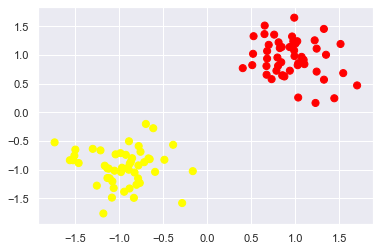

In [7]:
X, y = make_blobs(n_samples = 100,
                  centers = 2,
                  random_state = 1,
                  cluster_std = 1.5,
                  n_features = 2)

X = StandardScaler().fit_transform(X)
y[y == 0] = -1

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.show()

## SVMs mit linearen Kernel

In [8]:
C = 1000

smo_model_lin = SVMwithSMO(X, y, linear_kernel, C = C)
smo_model_lin.fit()

sgd_model = SVMwithSGD(X, y, C = C)
sgd_model.fit()

skl_model_lin = SVC(kernel = 'linear', C = C)
skl_model_lin.fit(X, y)

print("SMO, SGD und SKL SVM trainiert.")

SMO, SGD und SKL SVM trainiert.


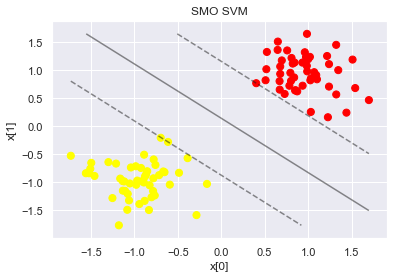

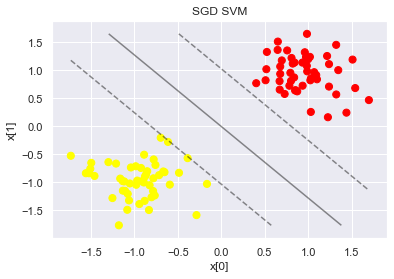

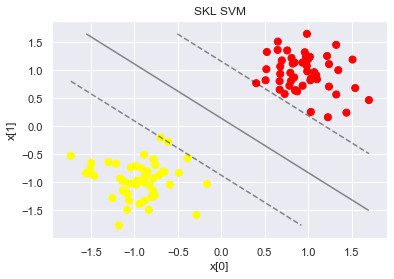

In [9]:
smo_model_lin.plot()
sgd_model.plot()
plot_svc_decision_function(skl_model_lin, X, y)

Alle drei SVMs teilen die Daten durch die geforderte Hyperebene. Allerdings ist zu erkennen, dass die Hyperebenen sich unterscheiden (bspw. variiert die jeweilige Steigung ). Als Gütekriterium kann der Abstand $a$ der Hyperebene der jeweiligen SVMs genutzt werden.

### Parameter der SVMs

In [10]:
print('SMO w: ' + str(smo_model_lin.w))
print('SMO m: ' + str(-smo_model_lin.w[0] / smo_model_lin.w[1]))
print('SMO b: ' + str(smo_model_lin.b))
print('SMO a: ' + str(1 / (math.sqrt(sum(i*i for i in smo_model_lin.w)))))
print("")

print('SGD w: ' + str(sgd_model.w))
print('SGD m: ' + str(-sgd_model.w[0] / sgd_model.w[1]))
print('SGD a: ' + str(1 / (math.sqrt(sum(i*i for i in sgd_model.w)))))
print("")

print('SKL w: ' + str(skl_model_lin.coef_[0]))
print('SKL m: ' + str (- skl_model_lin.coef_[0][0] / skl_model_lin.coef_[0][1]))
print('SKL b: ' + str(skl_model_lin.intercept_[0] / skl_model_lin.coef_[0][0]))
print('SKL a: ' + str(1 / (math.sqrt(sum(i*i for i in skl_model_lin.coef_[0])))))

SMO w: [-0.95400309 -0.98478231]
SMO m: -0.9687451511711329
SMO b: -0.14352891116197117
SMO a: 0.7293408444567968

SGD w: [-1.23939045 -0.97179895]
SGD m: -1.2753568496394265
SGD a: 0.6349389515607933

SKL w: [-0.95353701 -0.9843012 ]
SKL m: -0.9687451511711322
SKL b: -0.1504491039231443
SKL a: 0.7296973386443764


Wie schon bei der grafischen Betrachtung der Hyperebene aufgefallen ist, gleichen sich diese relativ stark. Vor allem bei der SMO und SKL SVM ist das der Fall. Der Abstand $a$ der SMO und der SKL SVM sind fast gleich groß, aber deutlich größer als der Abstand der SGD SVM. Auch die Steigung $m$ der SMO und SKL SVM gleichen sich stark.

### Vorhersage von unbekannten Datenpunkten

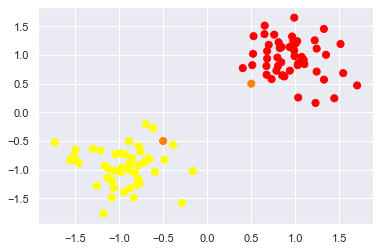

In [11]:
toPredict = [[-0.5,-0.5],[0.5,0.5]]

plt.scatter(np.append(X, toPredict, axis= 0)[:, 0], np.append(X, toPredict, axis= 0)[:, 1], c=np.append(y, [0,0], axis= 0), s=50, cmap='autumn')
plt.show()

In [12]:
print("SMO Vorhersagen: " + str(smo_model_lin.predict(toPredict, toClass = False)))
print("SGD Vorhersagen: " + str(sgd_model.predict(toPredict, toClass = False)))
print("SKL Vorhersagen: " + str(skl_model_lin.decision_function(toPredict)))

SMO Vorhersagen: [ 1.11292161 -0.82586379]
SGD Vorhersagen: [ 1.1055947 -1.1055947]
SKL Vorhersagen: [ 1.11237789 -0.82546031]


In [13]:
print("SMO Vorhersagen: " + str(smo_model_lin.predict(toPredict)))
print("SGD Vorhersagen: " + str(sgd_model.predict(toPredict)))
print("SKL Vorhersagen: " + str(skl_model_lin.predict(toPredict)))

SMO Vorhersagen: [ 1 -1]
SGD Vorhersagen: [ 1 -1]
SKL Vorhersagen: [ 1 -1]


Trotz der unterschiedlichen Parameter der SVMs klassifizieren diese korrekt.

### Hinzufügen von neuen Datenpunkten innerhalb von $w$

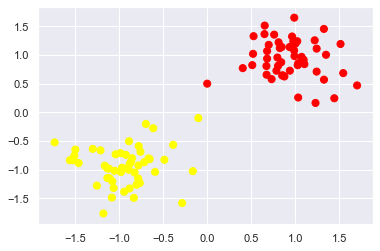

In [14]:
X_outlier = np.append(X, [[-0.1, -0.1], [0, 0.5]], axis=0)
y_outlier = np.append(y, [1, -1], axis = 0)

plt.scatter(X_outlier[:, 0], X_outlier[:, 1], c=y_outlier, s=50, cmap='autumn')
plt.show()

In [15]:
C = 1000

smo_model_lin_o = SVMwithSMO(X_outlier, y_outlier, linear_kernel, C = C)
smo_model_lin_o.fit()

sgd_model_o = SVMwithSGD(X_outlier, y_outlier, C = C)
sgd_model_o.fit()

skl_model_lin_o = SVC(kernel = 'linear', C = C)
skl_model_lin_o.fit(X_outlier, y_outlier)

print("SMO, SGD und SKL SVM trainiert.")

SMO, SGD und SKL SVM trainiert.


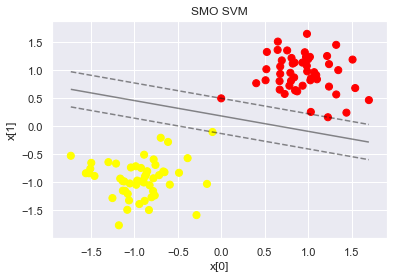

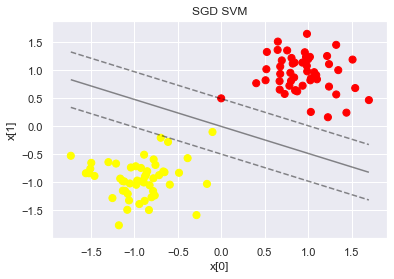

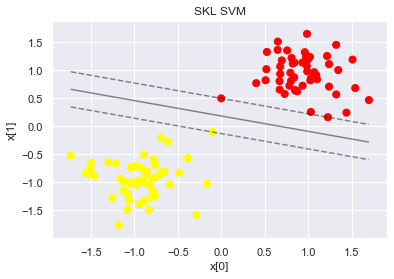

In [16]:
smo_model_lin_o.plot()
sgd_model_o.plot()
plot_svc_decision_function(skl_model_lin_o, X_outlier, y_outlier)

Aufgrund des hohen Strafterms $C$ verändert sich die Hyperebene der SMO und SKL SVM korrekt. Die SGD SVM allerdings benötigt höchstwahrscheinlich mehrere Iterationen oder ein besser gesteuerten Learning Rate, um eine ähnlich veränderte Hyperebene vorzeigen zu können.

### Datenset mit neuen Datenpunken und kleinerem C

In [17]:
C = 1

smo_model_lin_o = SVMwithSMO(X_outlier, y_outlier, linear_kernel, C = C)
smo_model_lin_o.fit()

sgd_model_o = SVMwithSGD(X_outlier, y_outlier, C = C)
sgd_model_o.fit()

skl_model_lin_o = SVC(kernel = 'linear', C = C)
skl_model_lin_o.fit(X_outlier, y_outlier)

print("SMO, SGD und SKL SVM trainiert.")

SMO, SGD und SKL SVM trainiert.


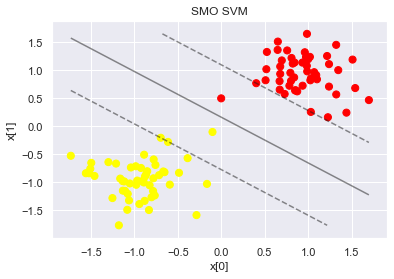

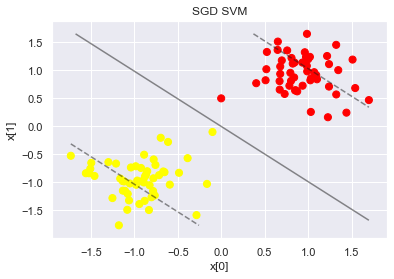

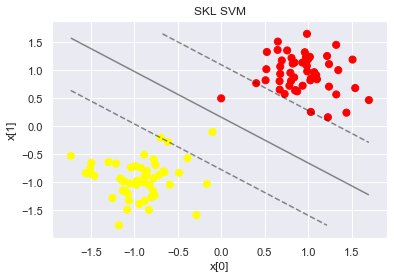

In [18]:
smo_model_lin_o.plot()
sgd_model_o.plot()
plot_svc_decision_function(skl_model_lin_o, X_outlier, y_outlier)

Auch hier zeigt sich, dass die SMO und SKL SVM relativ ähnlich handeln. Eine Verringerung des Starfterms bewirkt, das die hinzugefügten Datenpunkte innerhalb von $a$ liegen. Bei der SGD SVM bewirkt die Verringerung des Starfterms ein deutlich größeres $a$.

## SVMs mit polynomialen Kernel

Nun werden SMO und SKL SVMs mit polynomialen Kerneln eingesetzt. Aufgrund der rudimenteren Implementation der SGD SVM ist es nicht möglich einen Kernel zu benutzen.

In [19]:
c = 1000

smo_model_pol = SVMwithSMO(X, y, polynomial_kernel, C = C)
smo_model_pol.fit()

skl_model_pol = SVC(kernel = 'poly', C = C)
skl_model_pol.fit(X, y)

print("SMO und SKL SVM trainiert.")

SMO und SKL SVM trainiert.


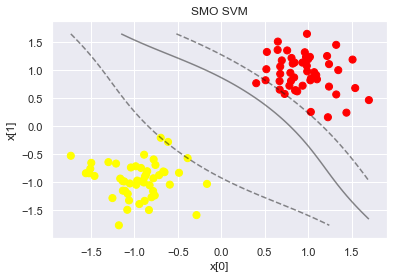

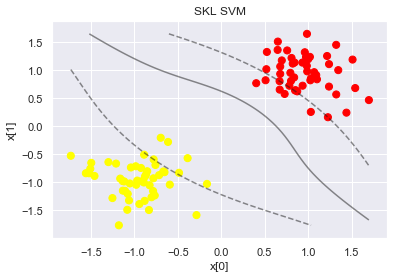

In [20]:
smo_model_pol.plot()
plot_svc_decision_function(skl_model_pol, X, y)

Wieder verhalten sich die beiden SVMs relativ ähnlich. Allerdings ist aufgrund der polynomialen Kernel keine Auswertung der oben aufgeführten Parameter möglich. Visuell erscheinen beide Hyperebene korrekt.

### Vorhersage von unbekannten Datenpunkten

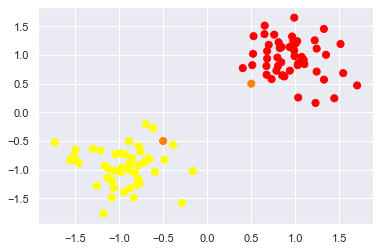

In [21]:
plt.scatter(np.append(X, toPredict, axis= 0)[:, 0], np.append(X, toPredict, axis= 0)[:, 1], c=np.append(y, [0,0], axis= 0), s=50, cmap='autumn')
plt.show()

In [22]:
print("SMO Vorhersagen: " + str(smo_model_pol.predict(toPredict, toClass = False)))
print("SKL Vorhersagen: " + str(skl_model_pol.decision_function(toPredict)))

SMO Vorhersagen: [ 1.0974263  -0.17722815]
SKL Vorhersagen: [ 0.46449965 -0.22365957]


In [23]:
print("SMO Vorhersagen: " + str(smo_model_pol.predict(toPredict)))
print("SKL Vorhersagen: " + str(skl_model_pol.predict(toPredict)))

SMO Vorhersagen: [ 1 -1]
SKL Vorhersagen: [ 1 -1]


Beide SVMs sagen die Datenpunkte korrekt voraus.

### Hinzufügen von neuen Datenpunkten

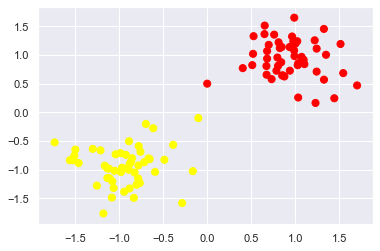

In [24]:
# X_outlier = np.append(X, [[-0.1, -0.1], [0.1, 0.1]], axis=0)
# y_outlier = np.append(y, [1, -1], axis = 0)

plt.scatter(X_outlier[:, 0], X_outlier[:, 1], c=y_outlier, s=50, cmap='autumn')
plt.show()

In [25]:
C = 1000

smo_model_pol_o_c  = SVMwithSMO(X_outlier, y_outlier, polynomial_kernel, C = C)
smo_model_pol_o_c.fit()

skl_model_pol_o_c = SVC(kernel = 'poly', C = C, gamma = "auto")
skl_model_pol_o_c.fit(X_outlier, y_outlier)

print("SMO und SKL SVM trainiert.")

SMO und SKL SVM trainiert.


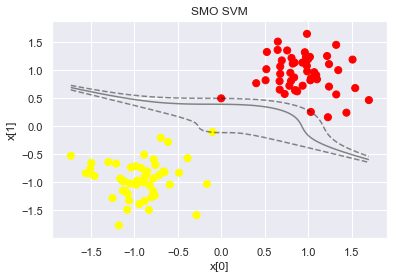

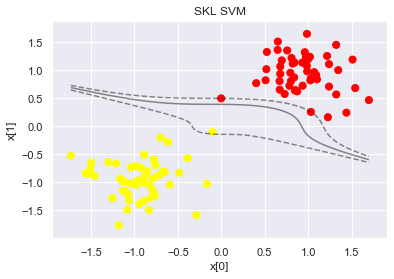

In [26]:
smo_model_pol_o_c.plot()
plot_svc_decision_function(skl_model_pol_o_c, X_outlier, y_outlier)

Es erfolgt eine korrekte Veränderung der Hyperebene aufgrund des hohen Strafterms.

### Datenset mit neuen Punken und kleinerem C

In [27]:
C = 1

smo_model_pol_o = SVMwithSMO(X_outlier, y_outlier, polynomial_kernel, C = C)
smo_model_pol_o.fit()

skl_model_pol_o = SVC(kernel = 'poly', C = C, gamma = "auto")
skl_model_pol_o.fit(X_outlier, y_outlier)

print("SMO, SGD und SKL SVM trainiert.")

SMO, SGD und SKL SVM trainiert.


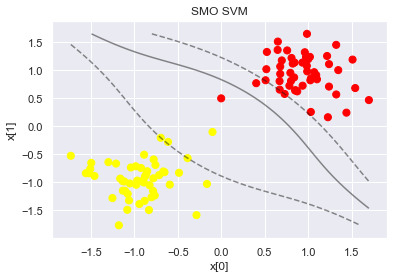

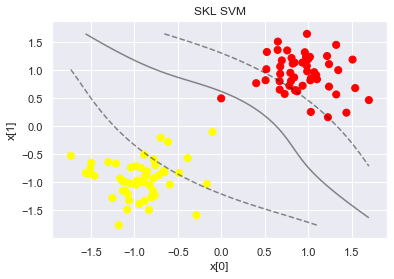

In [28]:
smo_model_pol_o.plot()
plot_svc_decision_function(skl_model_pol_o, X_outlier, y_outlier)

Aufgrund des geringen Strafterms können mehrere Datenpunkte innerhalb des Abstands der Hyperebene liegen.

## SMO SVM mit polynomial Kernel $p = 9$

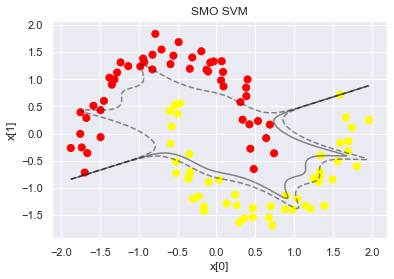

In [29]:
X, y = make_moons(n_samples=100, shuffle=True, noise=0.09, random_state=42)

X = StandardScaler().fit_transform(X)
y[y == 0] = -1

def polynomial_kernel_5(x, y, p = 9):				
	return (np.dot(x, y.T)) ** p

smo_model_pol = SVMwithSMO(X, y, polynomial_kernel_5, C = 1000)
smo_model_pol.fit()
smo_model_pol.plot()

Diese Grafik illustriert wie mächtig SVMs sein können. Häufig sind Daten nicht linear trennbar und von einer "normalen, linearen" SVM nicht bearbeitbar. Das ändert sich durch den Einsatz von Kerneln. In der Grafik sieht man, dass mit Hilfe eines polynomial Kernel eine relativ starke und korrekte Trennung erfolgen kann. Diese ist bei weitem noch nicht perfekt, könnte allerdings mit anderen Kerneln verbessert werden, wie bspw. einem RBF Kernel.